In [1]:
# Load stimuli
#%%#############################################################################
import os
from os import listdir
from os.path import isfile, join
from pathlib import Path

In [3]:
path_prefix = '/Users/zhuang/Documents/MRI/Projects/Travel/data/Resnet50/'
path_to_stimuli = Path('/Users/zhuang/Documents/MRI/Projects/Travel/data/Resnet50/images72/')

l_categories = [f.name[:3] for f in os.scandir(path_to_stimuli) if '.jpg' in f.name]
file_list = [f.name for f in os.scandir(path_to_stimuli) if '.jpg' in f.name]
print(f'{len(file_list)} stimuli successfully loaded!')

72 stimuli successfully loaded!


In [16]:
def load_categories():
    """Load categories."""
    with open(path_prefix + 'models/labels/category_momentsv1.txt') as f:
        return [line.rstrip() for line in f.readlines()]

# load categories
l_categories = load_categories() # 

In [10]:
categories_dict = {}
file_list = sorted(file_list)
l_categories = l_categories #sorted(l_categories)

for category in l_categories:
    categories_dict[str(category)] = file_list

for i in range(len(file_list)):
    category = l_categories[i]
    file = file_list[i]
    categories_dict[str(category)] = path_to_stimuli / file

print(categories_dict.keys())

dict_keys(['Motorrollerfahren1', 'Motorrollerfahren2', 'Motorrollerfahren3', 'Motorrollerfahren4', 'Motorrollerfahren5', 'Motorrollerfahren6', 'Fahrradfahren1', 'Fahrradfahren2', 'Fahrradfahren3', 'Fahrradfahren4', 'Fahrradfahren5', 'Fahrradfahren6', 'Kraulenschwimmen1', 'Kraulenschwimmen2', 'Kraulenschwimmen3', 'Kraulenschwimmen4', 'Kraulenschwimmen5', 'Kraulenschwimmen6', 'Rueckenschwimmen1', 'Rueckenschwimmen2', 'Rueckenschwimmen3', 'Rueckenschwimmen4', 'Rueckenschwimmen5', 'Rueckenschwimmen6', 'Biertrinken1', 'Biertrinken2', 'Biertrinken3', 'Biertrinken4', 'Biertrinken5', 'Biertrinken6', 'Wassertrinken1', 'Wassertrinken2', 'Wassertrinken3', 'Wassertrinken4', 'Wassertrinken5', 'Wassertrinken6', 'Apfelessen1', 'Apfelessen2', 'Apfelessen3', 'Apfelessen4', 'Apfelessen5', 'Apfelessen6', 'Kuchenessen1', 'Kuchenessen2', 'Kuchenessen3', 'Kuchenessen4', 'Kuchenessen5', 'Kuchenessen6', 'Fensterputzen1', 'Fensterputzen2', 'Fensterputzen3', 'Fensterputzen4', 'Fensterputzen5', 'Fensterputzen6',

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import os
from os import listdir
from os.path import isfile, join

import numpy as np
import matplotlib.pyplot as plt

In [12]:
transformation = transforms.Compose([
                                     transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])
])

<class 'PIL.JpegImagePlugin.JpegImageFile'>


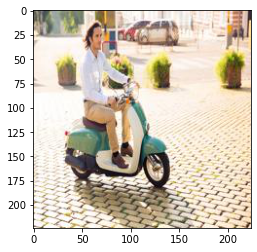

torch.Size([3, 224, 224])


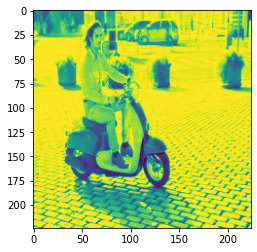

In [13]:
## Example of transformation ##
image_name = categories_dict['Motorrollerfahren1']

img = Image.open(image_name)#.convert('RGB')
print(type(img))
plt.imshow(np.asarray(img))
plt.show()

t_img = transformation(img)
print(t_img.shape)

plt.imshow(t_img[0])
plt.show()

In [14]:
## Load Model##
resnet50_moments = models.resnet50(pretrained=False, progress=True, num_classes=339)

In [15]:
# Path to ResNet50 MiTv1 categories:
path_to_pretrained = Path(path_prefix + 'models/weights/resnet50_moments-fd0c4436.pth')
resnet50_moments.load_state_dict(torch.load(path_to_pretrained))
resnet50_moments.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
##### Feature extraction function ####
from functools import partial
import collections
# network: a resnet50
net = resnet50_moments

# a dictionary that keeps saving the activations as they come

#activations.clear()
activations = collections.defaultdict(list)

def save_activation(name, mod, inp, out):
    activations[name].append(out)
    
n_hooks = 0
for name, m in net.named_modules():
    if type(m)==nn.Conv2d or type(m)==nn.AdaptiveAvgPool2d:
    #if type(m)==nn.ReLU:
        # partial to assign the layer name to each hook
        m.register_forward_hook(partial(save_activation, name))
        n_hooks += 1
        #print(name)

print('Registered hooks: ', n_hooks)

Registered hooks:  54


In [27]:
import torchvision.models as tmodels
dataset = []
# dummy data: 10 batches of images with batch size 16
for category in categories_dict.keys():
    #print(category)
    img = Image.open(categories_dict[category])
    img =  transformation(img)
    #print(img.shape)
    dataset.append(img)
    
print('Dataset ready!')
print('Nr. categories: ', len(dataset))
print('each with images:' , dataset[-1].shape)

Dataset ready!
Nr. categories:  72
each with images: torch.Size([3, 224, 224])


In [29]:
# Define dictionary with names of layers with means of activations
mean_activations_per_layer = {}

# forward pass through the full dataset
i = 0
#for batch in dataset[:23]: # batch = category containing 12 images
for batch in dataset: # batch = category containing 12 images
    print('\n{}/{}'.format(i+1, len(dataset)))
    j = 0

    #print('At the beggining: ', len(activations))
    activations.clear()
    activations = collections.defaultdict(list)
    
    
    out = net(batch.unsqueeze(0))
    #print(net(view.unsqueeze(0)).shape)
    j+=1

    #print('After: ', len(activations))
    #print('Number of activations collected in layer {}: {}'.format('conv1', len(activations['conv1'])))

    activations = {name: torch.cat(outputs, 0) for name, outputs in activations.items()}

    activations_per_layer_dict = {}
    for name, outputs in activations.items():
        #print(torch.mean(outputs, dim=0).shape)
        activations_per_layer_dict[str(name)] = torch.mean(outputs, dim=0)

    mean_activations_per_layer[l_categories[i]] = activations_per_layer_dict
            
    i+=1

print('Features extracted!')

print('Number of categories swept: ', len(mean_activations_per_layer))


1/72

2/72

3/72

4/72

5/72

6/72

7/72

8/72

9/72

10/72

11/72

12/72

13/72

14/72

15/72

16/72

17/72

18/72

19/72

20/72

21/72

22/72

23/72

24/72

25/72

26/72

27/72

28/72

29/72

30/72

31/72

32/72

33/72

34/72

35/72

36/72

37/72

38/72

39/72

40/72

41/72

42/72

43/72

44/72

45/72

46/72

47/72

48/72

49/72

50/72

51/72

52/72

53/72

54/72

55/72

56/72

57/72

58/72

59/72

60/72

61/72

62/72

63/72

64/72

65/72

66/72

67/72

68/72

69/72

70/72

71/72

72/72
Features extracted!
Number of categories swept:  72


In [30]:
##### RDM calculation
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import spearmanr

In [31]:
def rdm_per_layer_(X,
                   metric='cosine'):
    """
    Function to calculate the dissimilarity matrix by means of pair-wise distances
    between elements of X, using a predefined metric.
    
    Parameters:
    -----------
    X : (n_features, n_observations) ndarray
        Used to calculate the RDM from.
    metric : str, optional
        The metric to be used. Default: 'cosine'.
        From scikit-learn: [‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’].
        From scipy.spatial.distance: [‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘correlation’,
        ‘dice’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘minkowski’, ‘rogerstanimoto’,
        ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’'spearman'.
        
    n_actions : int, optional
        Number of stimuli that will determin the shape of the final RDM: (n_actions, n_actions).
        Default: len(l_categories)

    """
    # Calculate the distance matrix
    if metric == 'cosine':
        #print('Cosine-RDM was calculated!')
        return pairwise_distances(X=X,
                                  Y=X, 
                                  metric='cosine')
    elif metric == 'euclidean':
        #print('Euclidean-RDM was calculated!')
        return euclidean_distances(X=X, Y=X)
    else:
        #print('{} RDM was calculated!'.format(metric))
        return pairwise_distances(X=X,
                                  Y=X,
                                  metric=metric)



#%%#############################################################################
# Define n_layers RDMs: (n_layers, n_actions, n_actions)
rdms_per_layer = np.zeros((len(mean_activations_per_layer['Motorrollerfahren1']),
                           len(mean_activations_per_layer),
                           len(mean_activations_per_layer)))
print(rdms_per_layer.shape)

(54, 72, 72)


In [32]:
metric = 'correlation' # (1-r)

i = 0
for layer in mean_activations_per_layer['Motorrollerfahren1'].keys():
    print(layer)
    features_ = []
    for category in mean_activations_per_layer.keys():
        #print(category, mean_activations_per_layer[category][layer].flatten().detach().numpy().shape)
        #print(mean_activations_per_layer[category][layer].flatten().detach().numpy()[:10])
        features_.append(mean_activations_per_layer[category][layer].flatten().detach().numpy())

    #print(np.array(features_).shape)
    rdms_per_layer[i] = rdm_per_layer_(np.array(features_),
                                       metric)
    i+=1

conv1
layer1.0.conv1
layer1.0.conv2
layer1.0.conv3
layer1.0.downsample.0
layer1.1.conv1
layer1.1.conv2
layer1.1.conv3
layer1.2.conv1
layer1.2.conv2
layer1.2.conv3
layer2.0.conv1
layer2.0.conv2
layer2.0.conv3
layer2.0.downsample.0
layer2.1.conv1
layer2.1.conv2
layer2.1.conv3
layer2.2.conv1
layer2.2.conv2
layer2.2.conv3
layer2.3.conv1
layer2.3.conv2
layer2.3.conv3
layer3.0.conv1
layer3.0.conv2
layer3.0.conv3
layer3.0.downsample.0
layer3.1.conv1
layer3.1.conv2
layer3.1.conv3
layer3.2.conv1
layer3.2.conv2
layer3.2.conv3
layer3.3.conv1
layer3.3.conv2
layer3.3.conv3
layer3.4.conv1
layer3.4.conv2
layer3.4.conv3
layer3.5.conv1
layer3.5.conv2
layer3.5.conv3
layer4.0.conv1
layer4.0.conv2
layer4.0.conv3
layer4.0.downsample.0
layer4.1.conv1
layer4.1.conv2
layer4.1.conv3
layer4.2.conv1
layer4.2.conv2
layer4.2.conv3
avgpool


In [34]:
# Save RDMs
file_name = 'RN50_MiTv1_TwinsetFusion156_Conv2D&AvgPool_RDMs_{}.npy'.format(metric)
output_file = Path('outputs') / file_name
np.save(output_file, rdms_per_layer)
# Save layers names
layer_names = list(mean_activations_per_layer[next(iter(categories_dict))].keys())
file_name = 'RN50_MiTv1_TwinsetFusion156_Conv2D&AvgPool_RDMs_layers.txt'
np.savetxt(Path('outputs') / file_name,
           layer_names, delimiter=',', fmt='%s')

In [35]:
##### RDM visualization:
#Single layer's RDM:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

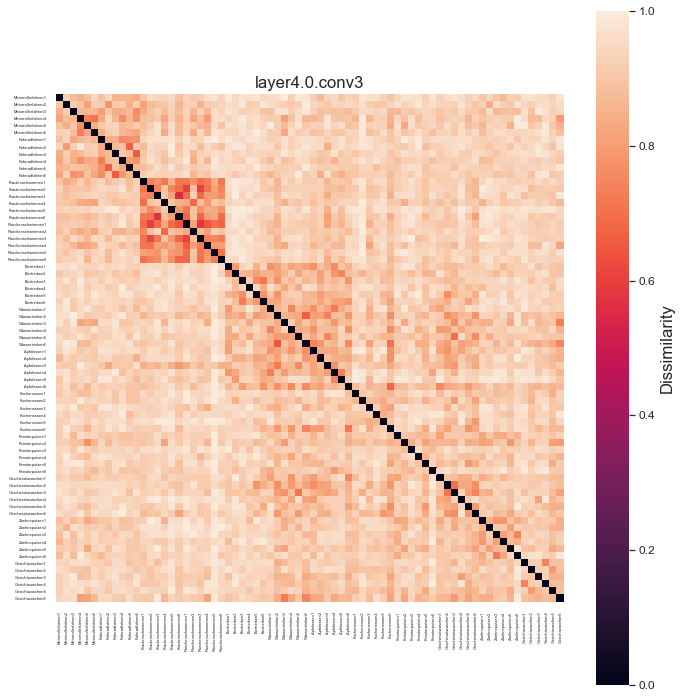

In [36]:
sns.set(font_scale=1.4)

plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

layer_nr = 45
title = layer_names[layer_nr]
rdm = rdms_per_layer[layer_nr]

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(preprocessing.normalize(rdm, 'max'),
                    xticklabels=l_categories, yticklabels=l_categories,
                    square=True,
                    cbar_kws={'label': 'Dissimilarity'})
plt.xticks(fontsize=4)
plt.yticks(fontsize=4)
ax.set_title(title)
fig.tight_layout()
plt.savefig(Path(f'plots/RN50_MiTv1_TwinsetFusion156_RDM_{title}.png'),
            dpi=400)



avgpool
conv1
layer1.0.conv1
layer1.0.conv2
layer1.0.conv3
layer1.0.downsample.0
layer1.1.conv1
layer1.1.conv2
layer1.1.conv3
layer1.2.conv1
layer1.2.conv2
layer1.2.conv3
layer2.0.conv1
layer2.0.conv2
layer2.0.conv3
layer2.0.downsample.0
layer2.1.conv1
layer2.1.conv2
layer2.1.conv3
layer2.2.conv1


/Users/zhuang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


layer2.2.conv2
layer2.2.conv3
layer2.3.conv1
layer2.3.conv2
layer2.3.conv3
layer3.0.conv1
layer3.0.conv2
layer3.0.conv3
layer3.0.downsample.0
layer3.1.conv1
layer3.1.conv2
layer3.1.conv3
layer3.2.conv1
layer3.2.conv2
layer3.2.conv3
layer3.3.conv1
layer3.3.conv2
layer3.3.conv3
layer3.4.conv1
layer3.4.conv2
layer3.4.conv3
layer3.5.conv1
layer3.5.conv2
layer3.5.conv3
layer4.0.conv1
layer4.0.conv2
layer4.0.conv3
layer4.0.downsample.0
layer4.1.conv1
layer4.1.conv2
layer4.1.conv3
layer4.2.conv1
layer4.2.conv2
layer4.2.conv3


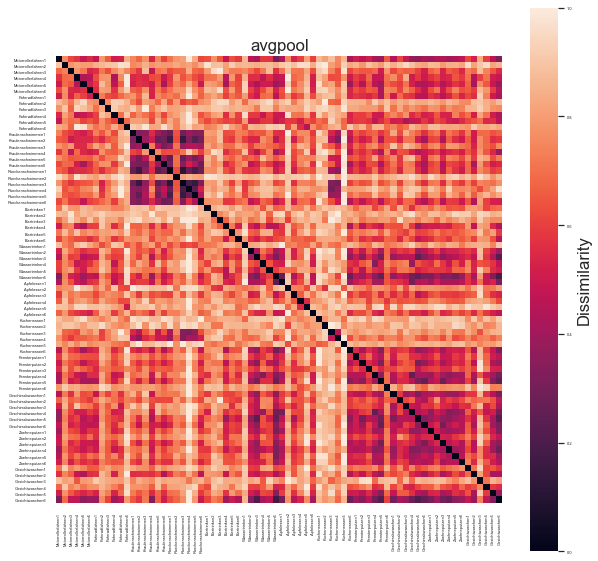

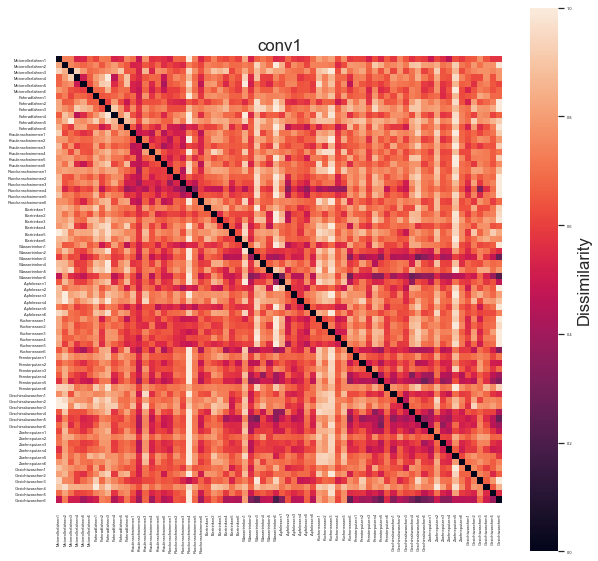

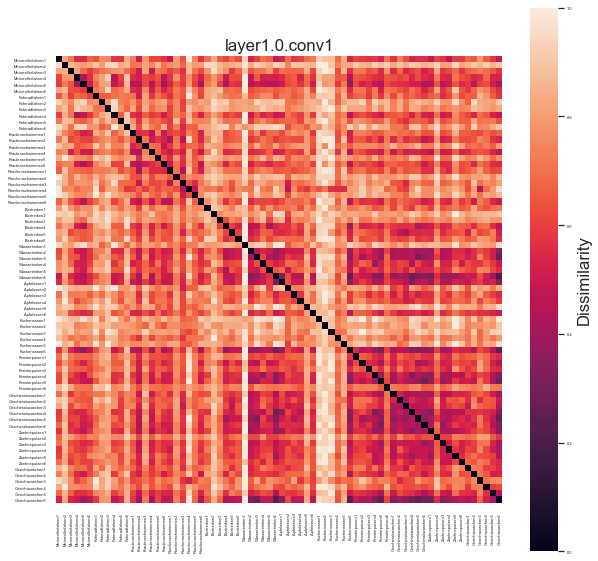

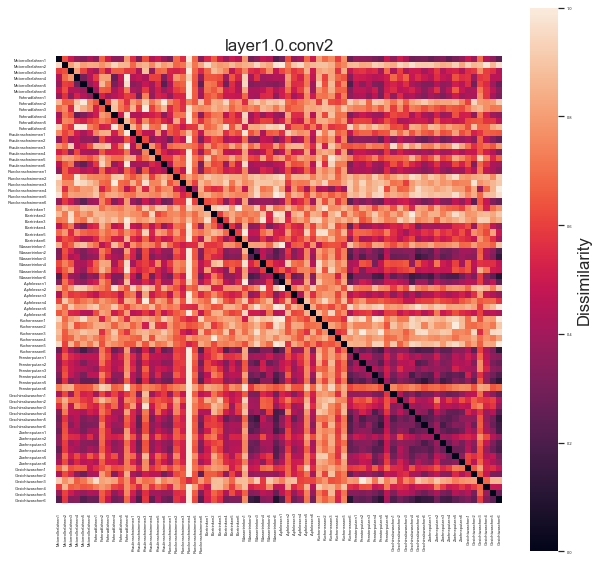

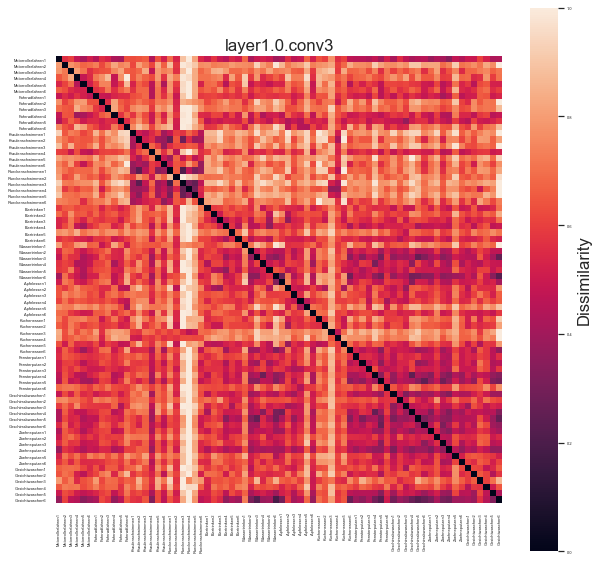

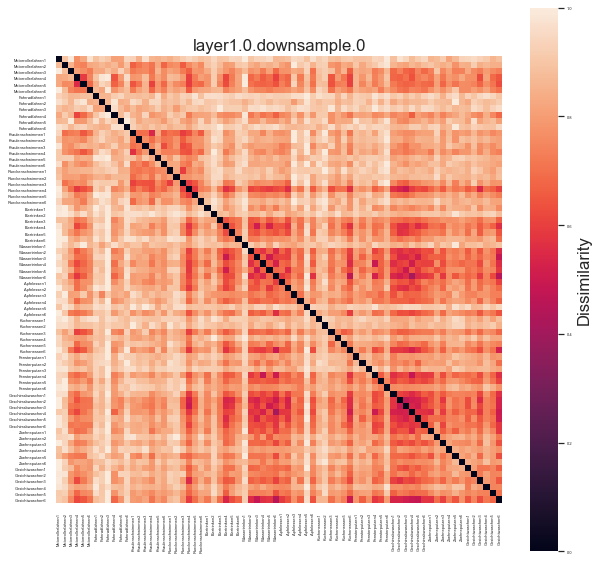

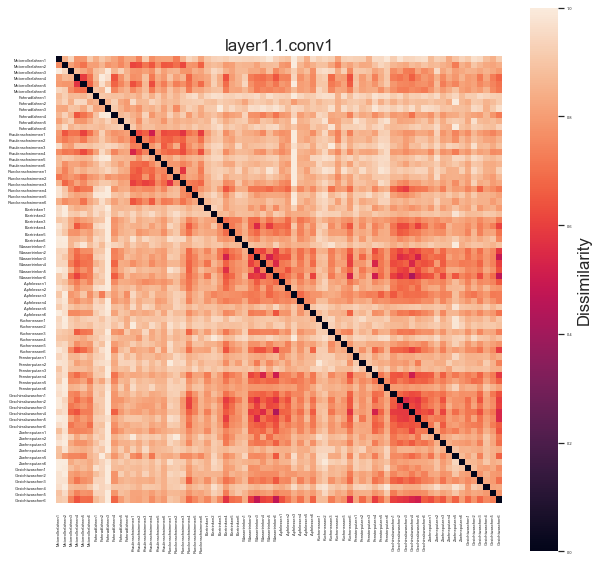

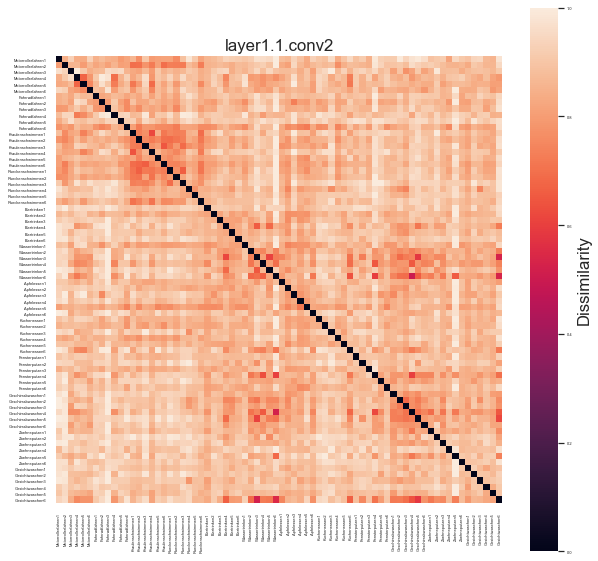

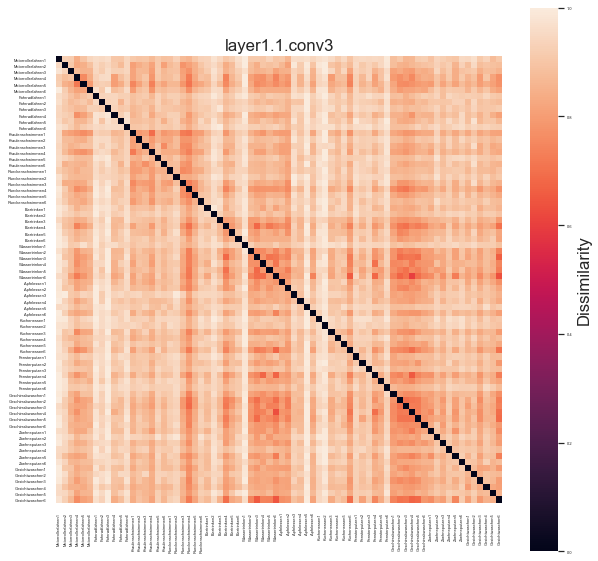

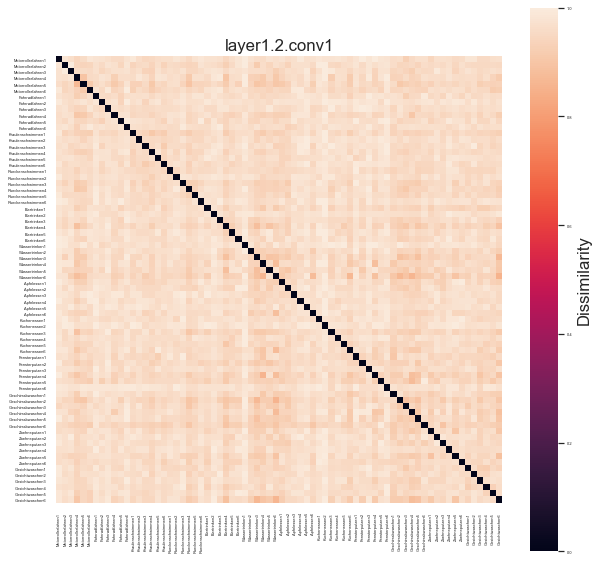

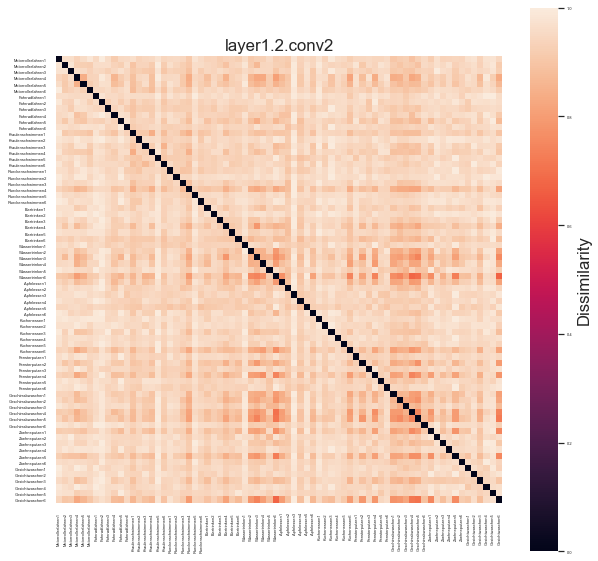

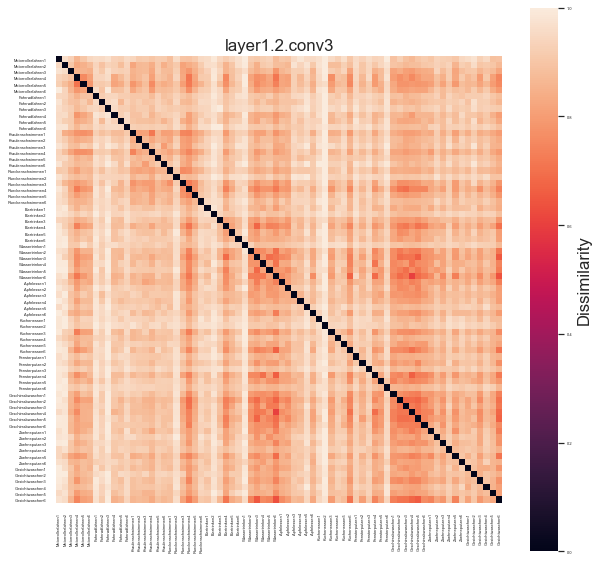

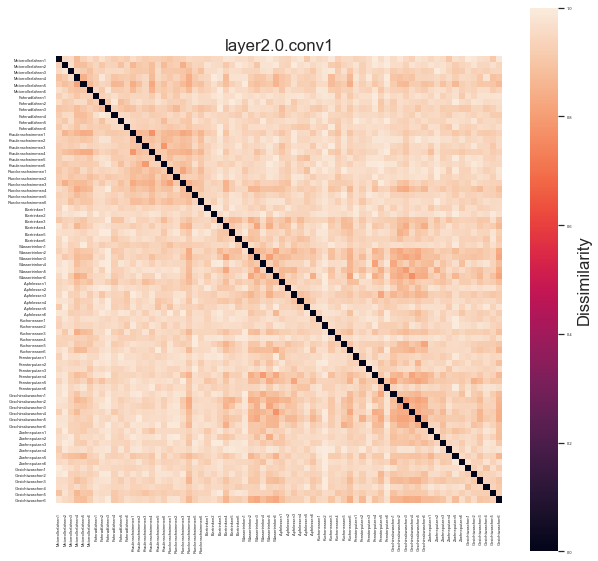

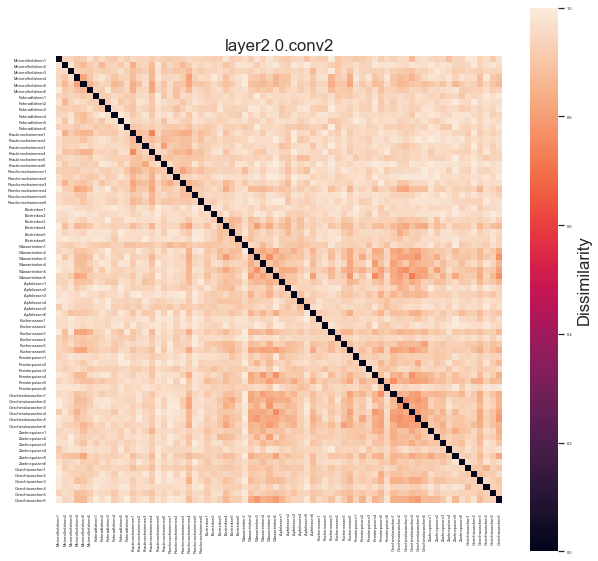

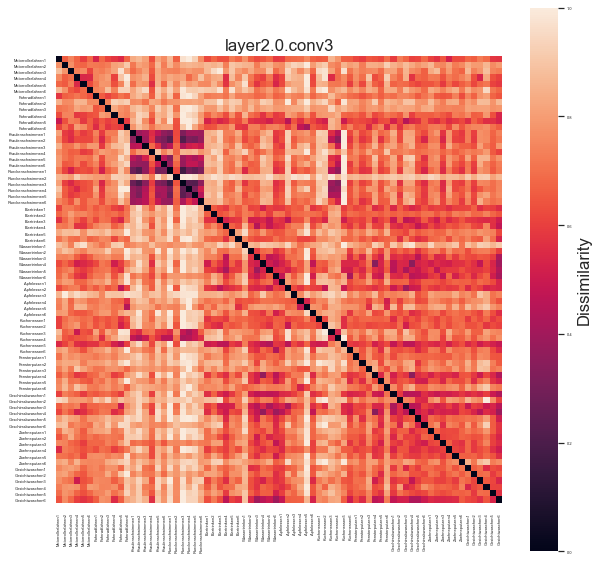

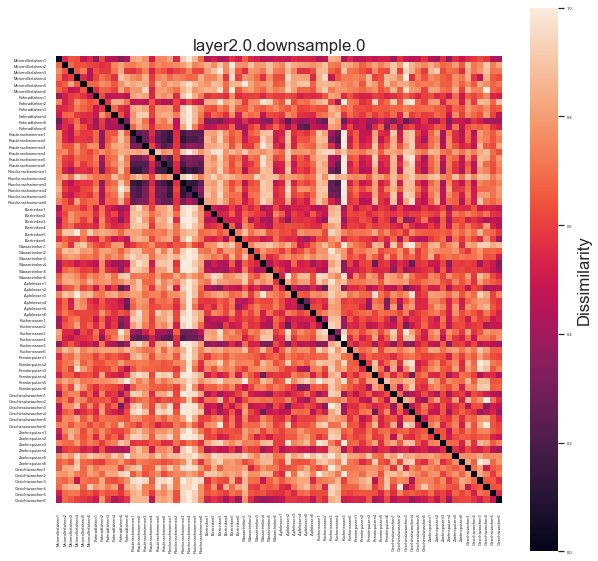

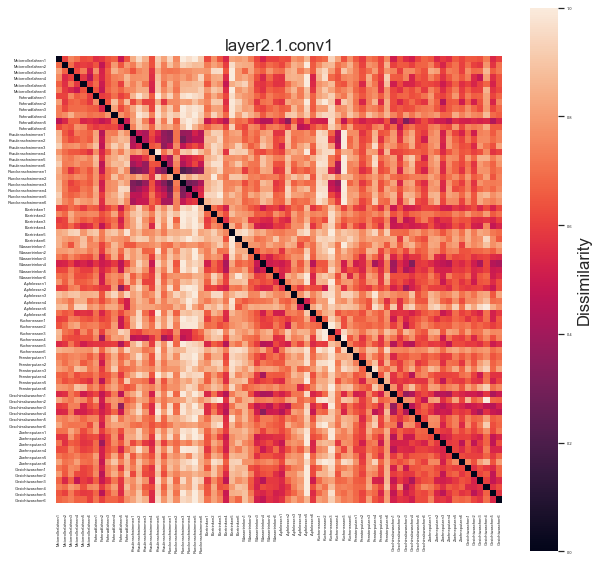

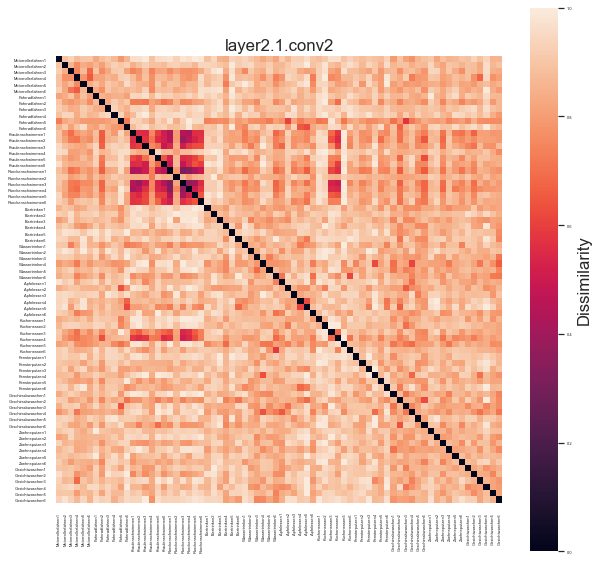

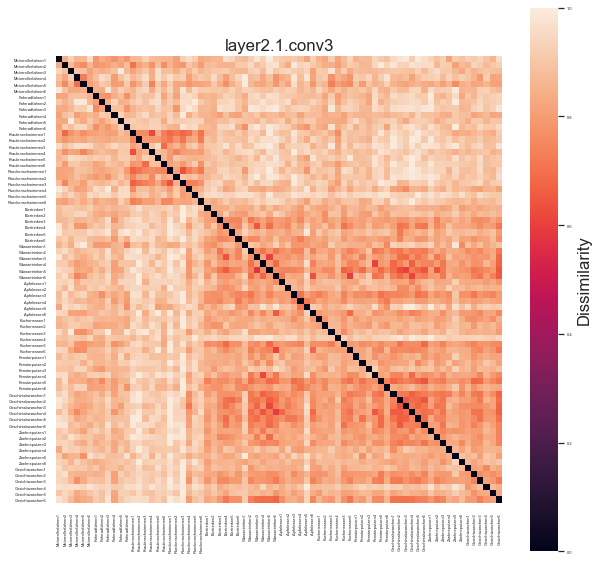

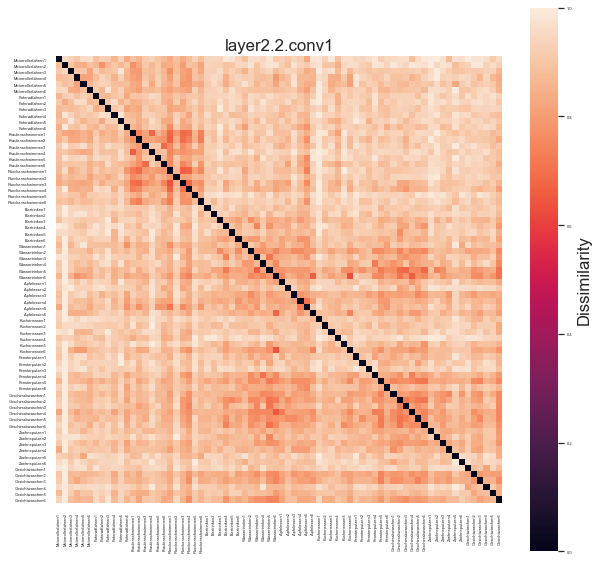

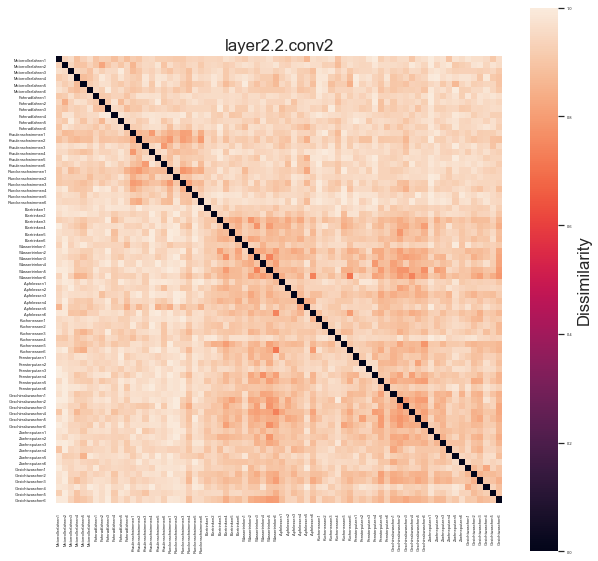

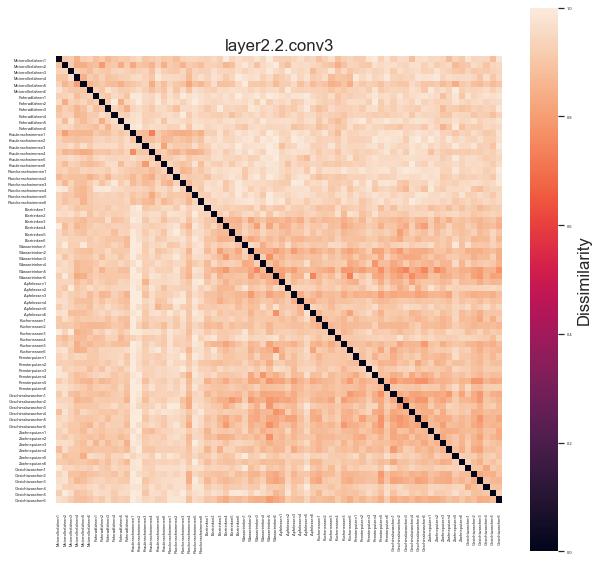

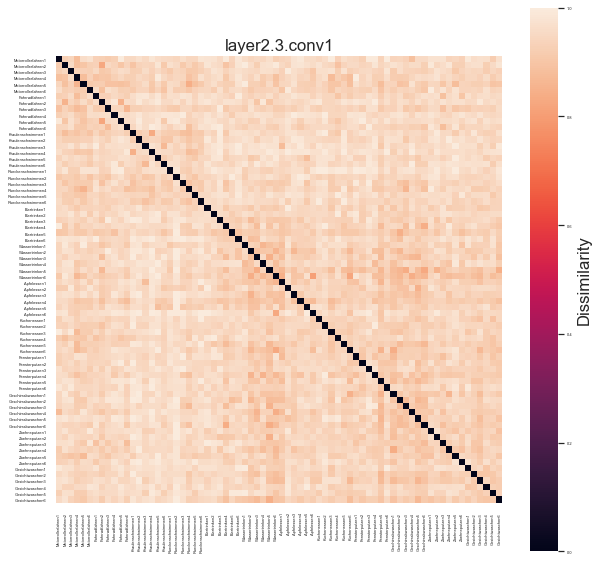

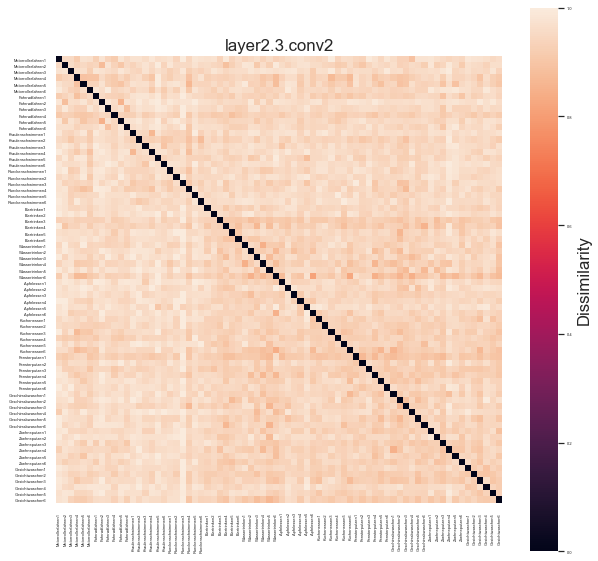

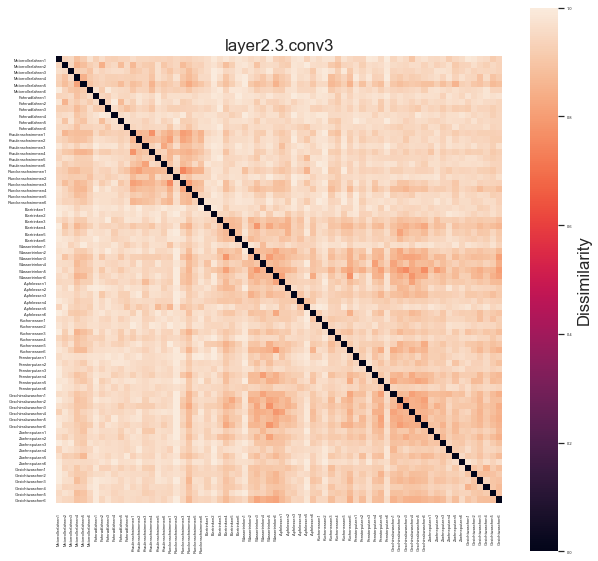

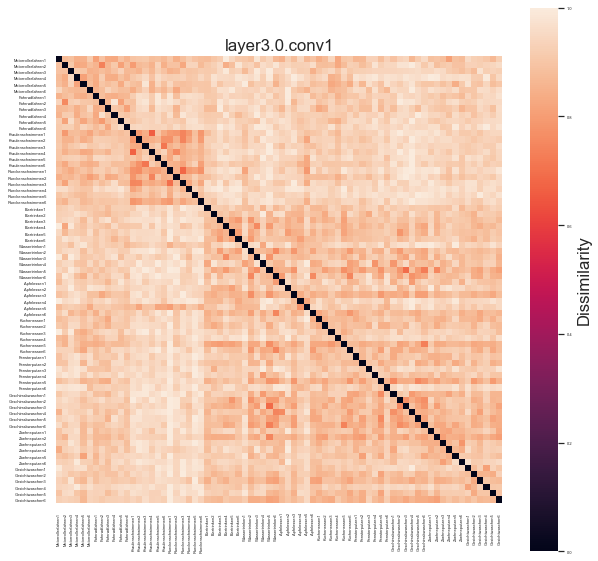

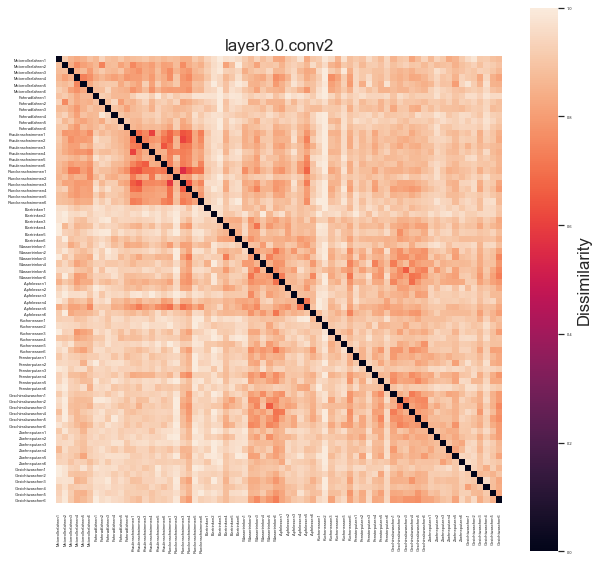

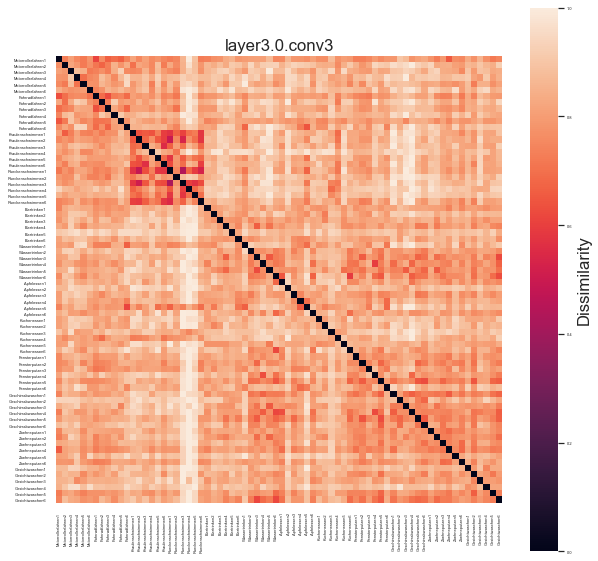

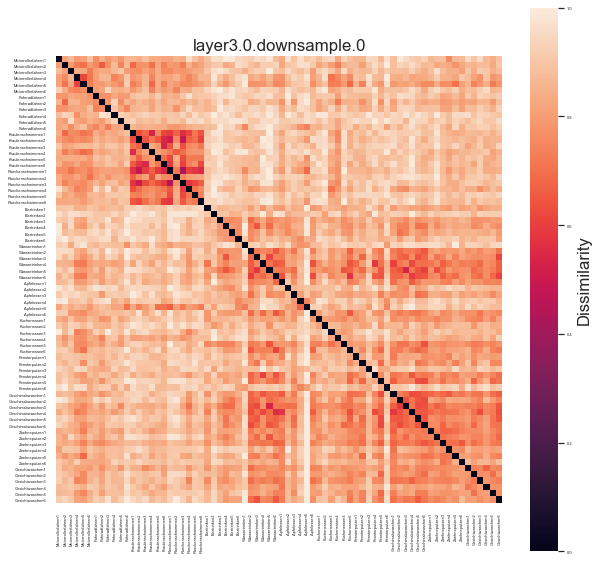

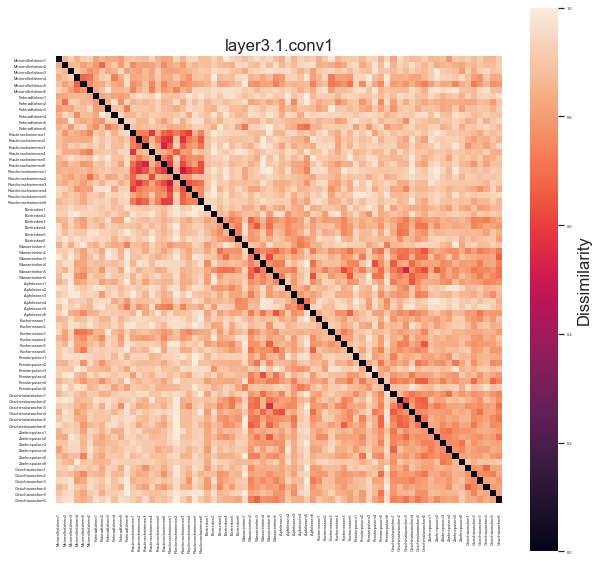

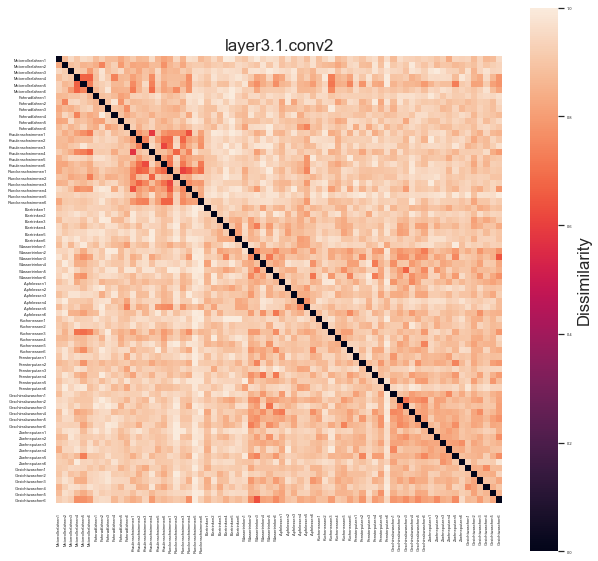

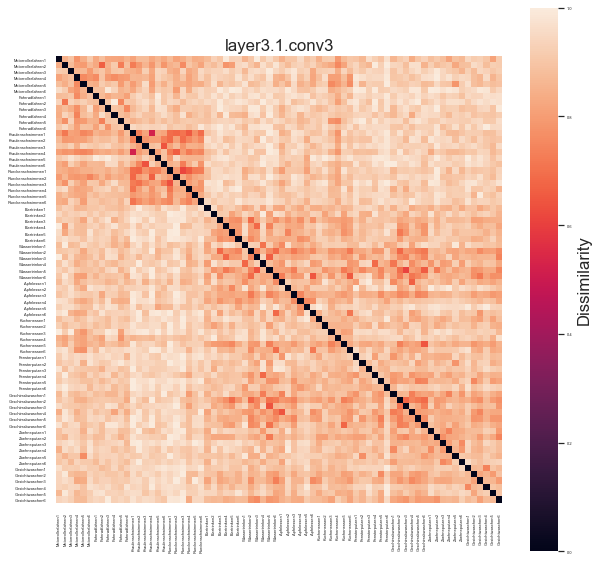

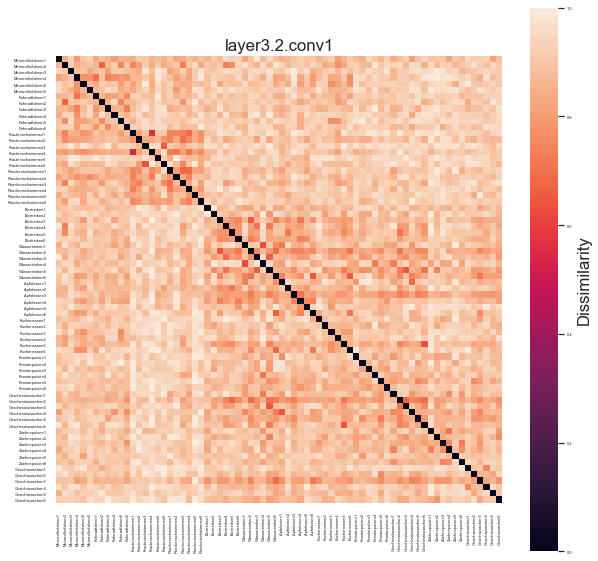

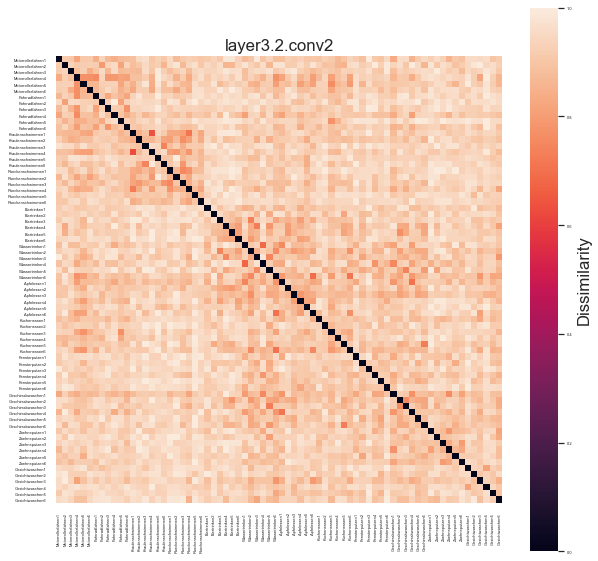

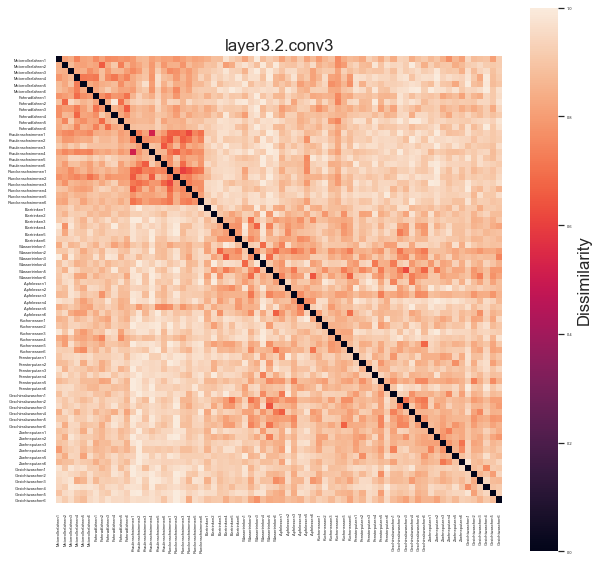

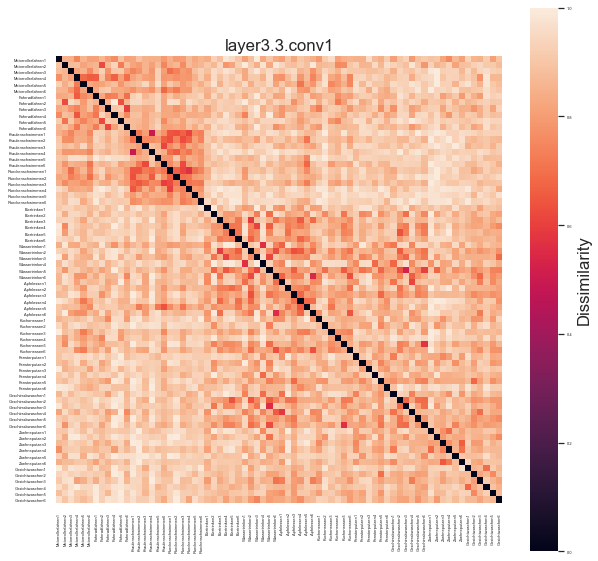

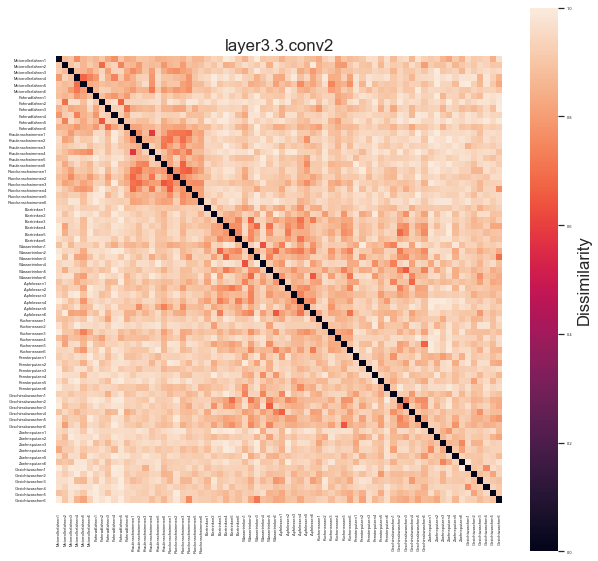

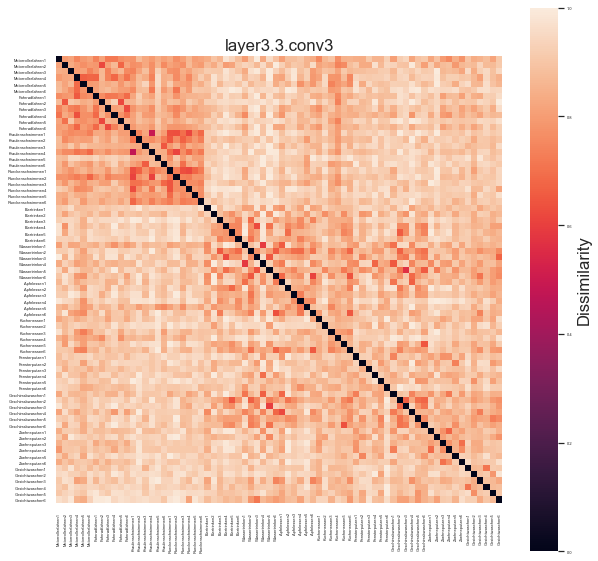

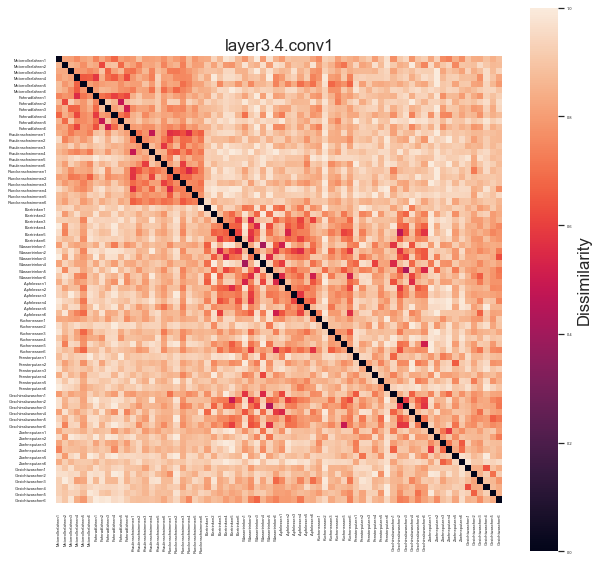

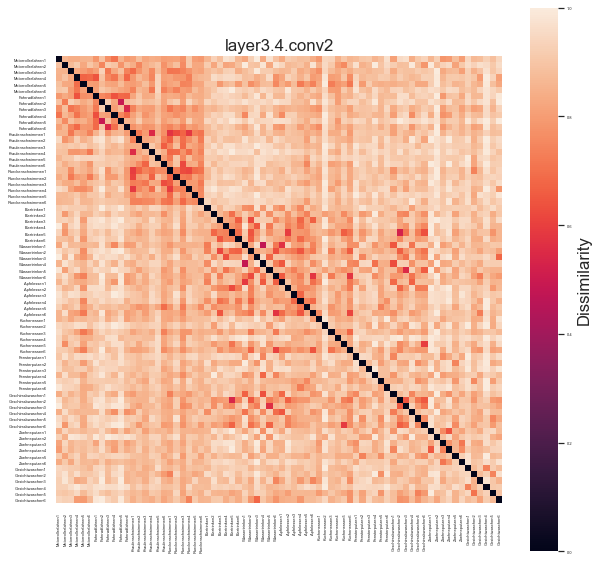

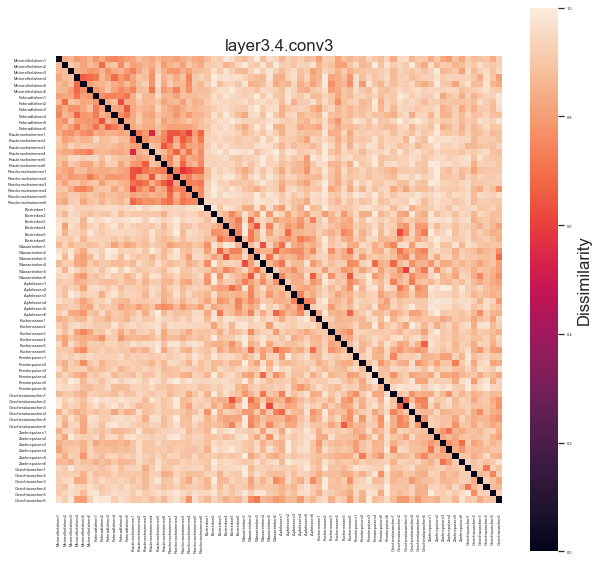

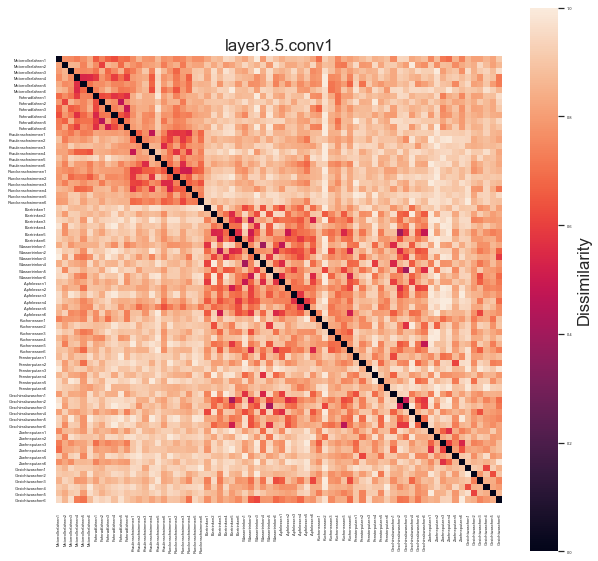

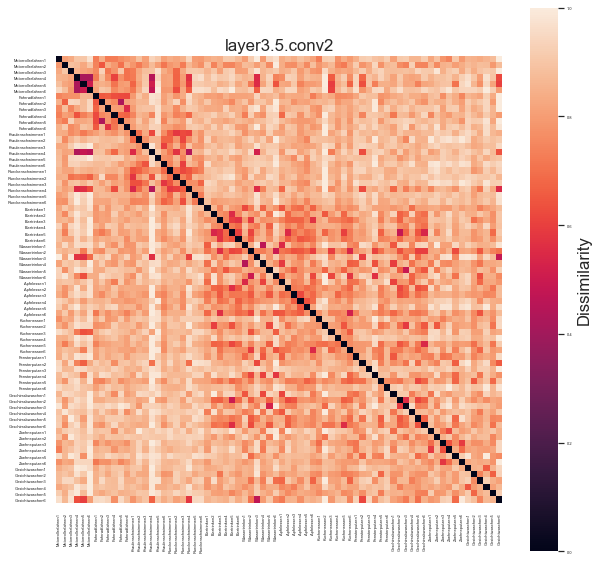

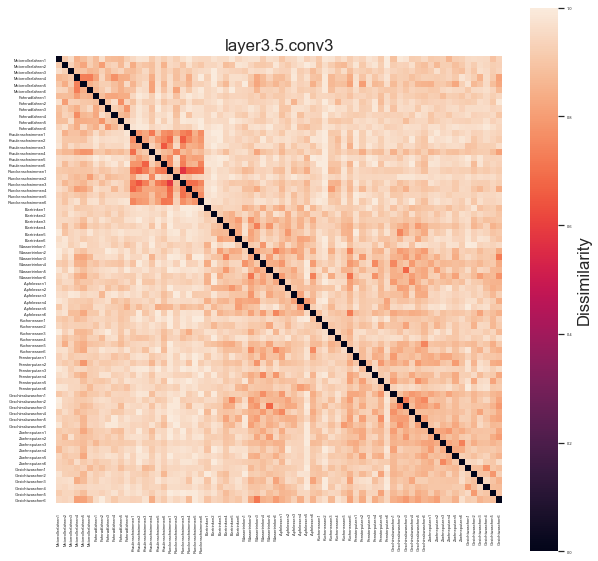

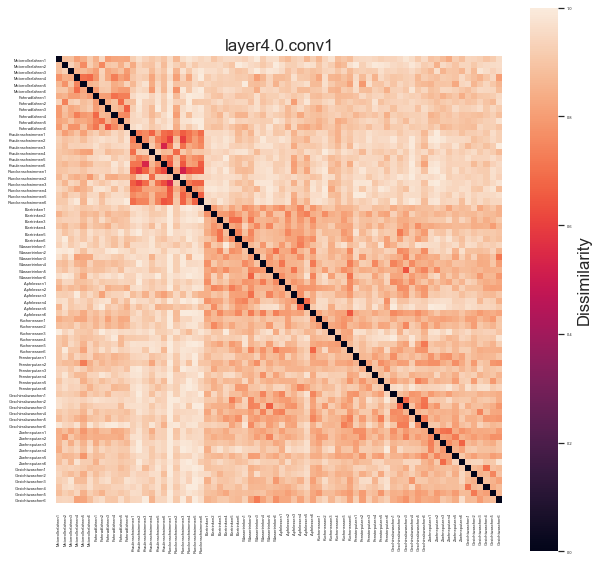

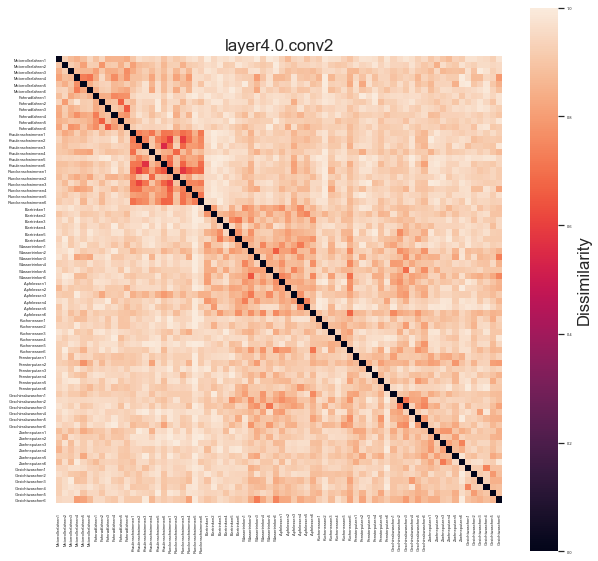

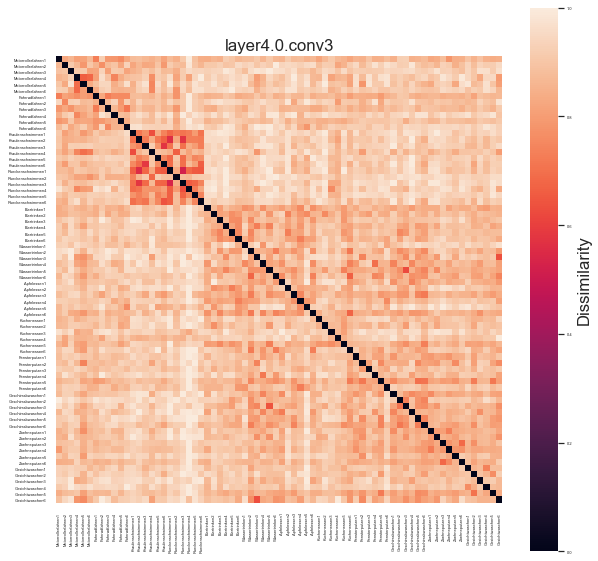

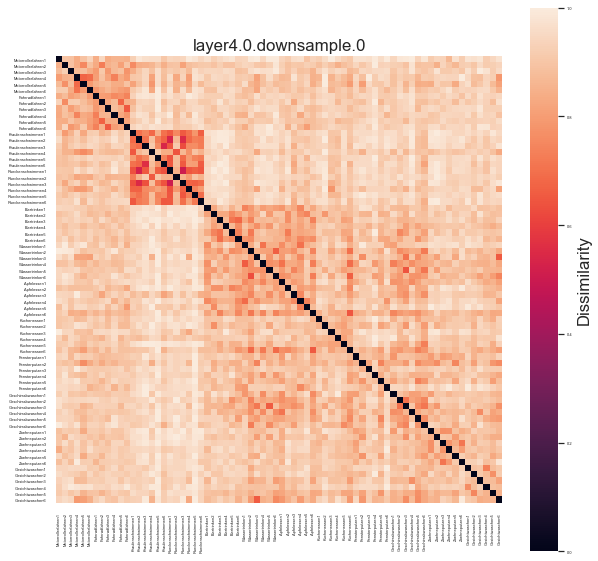

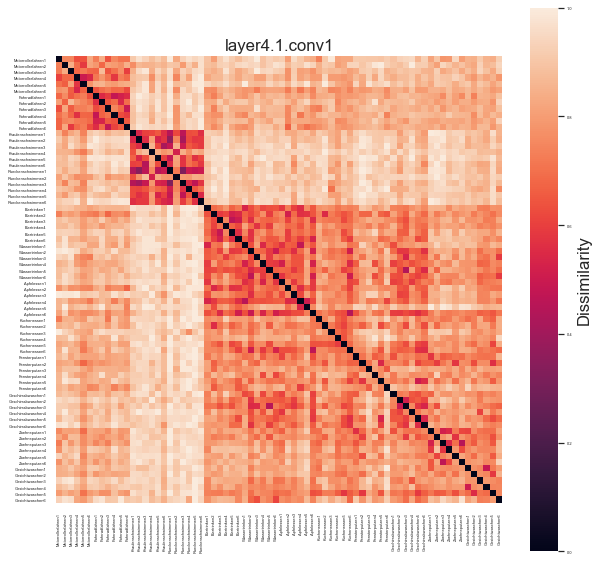

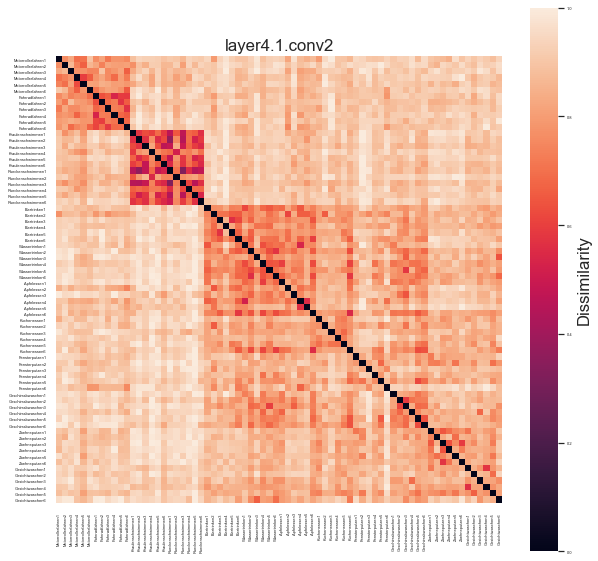

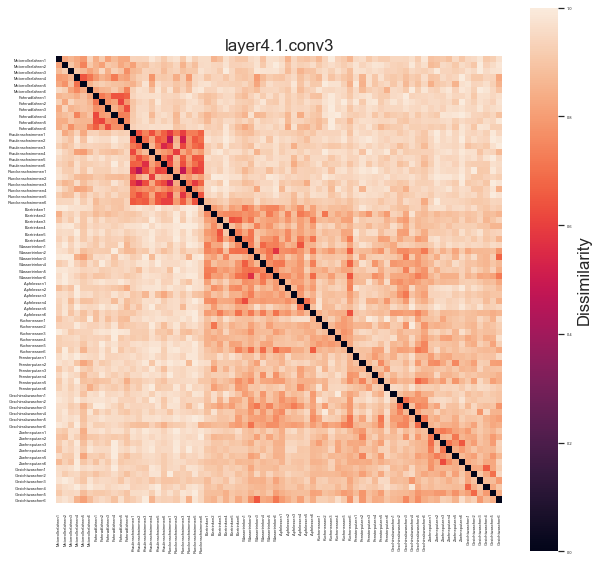

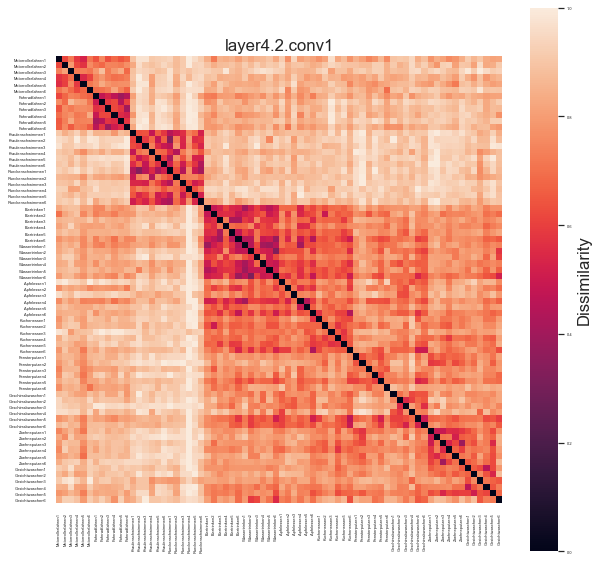

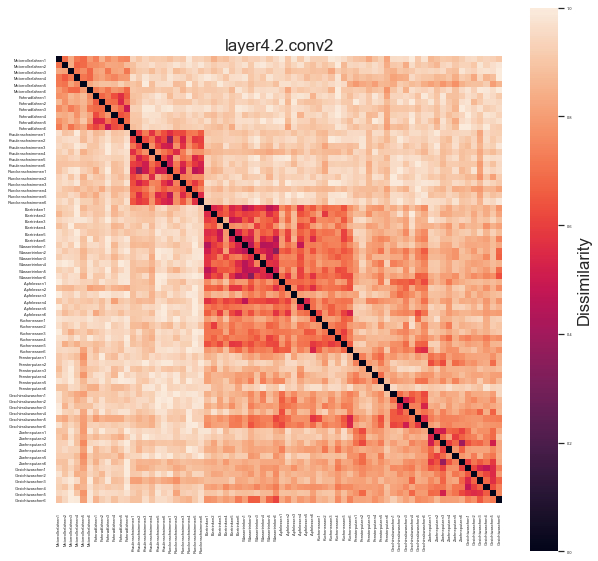

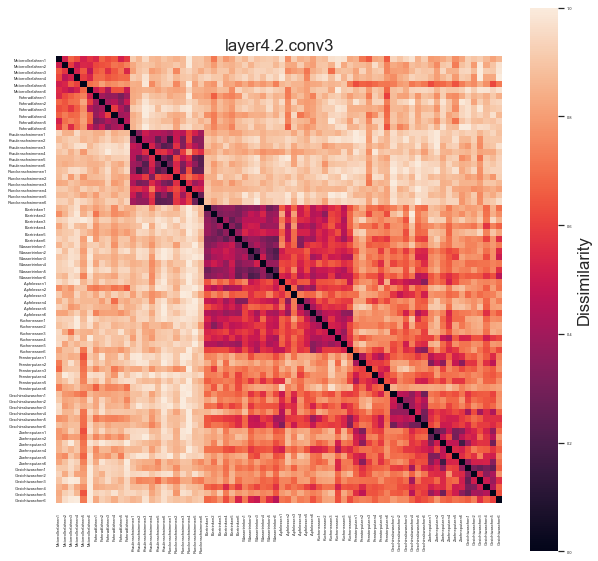

In [51]:
##Let's plot RDMs from the last 5 layers
plotpath='/Users/zhuang/Documents/MRI/Projects/Travel/data/Resnet50/plots/'
sns.set(font_scale=1.4)

plt.rcParams['xtick.labelsize']=4
plt.rcParams['ytick.labelsize']=4

start = rdms_per_layer.shape[0] -54
i=start
for rdm in rdms_per_layer[start:]:
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(preprocessing.normalize(rdm, 'max'),
                     xticklabels=l_categories, yticklabels=l_categories,
                     square=True,
                     cbar_kws={'label': 'Dissimilarity'})
    ax.set_title(layer_names[i-1])
    print(layer_names[i-1])
    fig.savefig(plotpath + 'action_' + layer_names[i-1] + '.png',dpi=400)
    i+=1

In [38]:
rdms_per_layer.shape

(54, 72, 72)